# NLP Project Sentiment Analysis with BERT
## Biontech data December 2021

Label description:
* 0: positive sentiment
* 1: negative sentiment
* None: no label

## Setup

In [27]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install tensorflow --quiet 
!pip install sklearn --quiet
!pip install tensorflow-addons --quiet

In [28]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix
from huggingface_hub import notebook_login
from transformers.keras_callbacks import PushToHubCallback
from transformers import create_optimizer


In [29]:
#Connect to google drive: JULE SPECIFIC (change to your drive or updata the data to colab manually and change working directory respective to that)
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/NLP/Project/')
root_dir = os.getcwd()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [30]:
# To use the data I import it as a pandas data frame
dataset = pd.read_csv('data/Biontech.csv')

## Explore the data

###Plots and Data

In [ ]:
dataset.head(3)

,created_at,id,username,name,user_id,body,basic_sentiment
0,2021-12-31 23:32:20+00:00,422493745,Witstock,Colin Robinson,3315545,$MRNA $bntx RIP Betty…$spy $qqq $pfe,0.0
1,2021-12-31 23:26:39+00:00,422492859,15HY,ARN,5380284,$BNTX $PFE https://ig.ft.com/coronavirus-vacci...,0.0
2,2021-12-31 23:00:54+00:00,422488662,academyofstocks,Academy of Stocks,546853,Oversold stocks to buy in 2022 using DCF \n\n$...,NaN


In [ ]:
dataset.columns


Index(['created_at', 'id', 'username', 'name', 'user_id', 'body',
       'basic_sentiment'],
      dtype='object')

In [ ]:
#Look at tweets
print(dataset['body'][3])

$BNTX Happy new year longs!!


In [ ]:
# Make a histogramm of the labels
#sns.countplot(dataset['basic_sentiment'],label='Count')
#label imbalance
#stratified train test split (Verteilung beider labels sollte in splitted datasets das gleiche Verhältnis haben) sklearn function hat das
#when training the model there is a parameter "importance/weights" (tensor flow bei model.fit classweight oder sample_weigth)
#Bei evaluierung nicht accuracy wählen!  confusion matrix  anschauen (F1 score, F beta score, precision recall)

In [ ]:
#Length of the tweets
#generate an additional column that contains the length of the tweets
dataset['length']=dataset['body'].apply(len)
dataset['length'].describe()

count    6799.000000
mean      184.414179
std       187.634714
min         5.000000
25%        58.000000
50%       126.000000
75%       241.000000
max      1163.000000
Name: length, dtype: float64

In [ ]:
#shortest tweet
print(dataset[dataset['length']==5]['body'].iloc[0])
#longest tweet
print(dataset[dataset['length']==1163]['body'].iloc[0])

$BNTX
$BNTX $PFE “The latest uptick feels as if we’re being flung back to 2020 again, when canceling plans was the norm and businesses were closing to “flatten the curve.”

In New York, some restaurants have shut their doors, not because the city forced them to but because their staff members have called out sick, and there is no one to replace them. Many Broadway shows have gone dark, often minutes before showtime, as cast members test positive. Cornell shut down its Ithaca, N.Y., campus after more than 900 community members tested positive in a week, many with the Omicron variant. And companies across the country have called off everything from holiday parties to return-to-office timetables and in-person meetings.

Vaccines, especially boosters, still seem to be largely effective against preventing severe disease.”

https://messaging-custom-newsletters.nytimes.com/template/oakv2?campaign_id=154&amp;emc=edit_cb_20211216&amp;instance_id=48026&amp;nl=coronavirus-briefing&amp;productCode

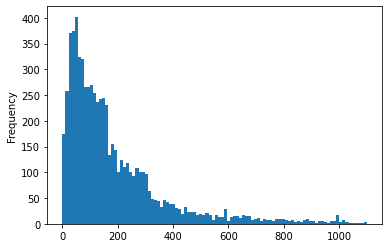

In [ ]:
#histogramm of tweet length
dataset['length'].plot(bins=100,kind='hist',range = [0,1100])

###Create a WordCloud

In [ ]:
#Postitive labels
positive = dataset[dataset['basic_sentiment']==0]
negative = dataset[dataset['basic_sentiment']== 1]

#Turn all tweets into one string 
sentences = dataset['body'].tolist() #turns the tweet column into a list
len(sentences) # list has same length as number of tweets
sentences_as_one_string = "".join(sentences) # turns all sequences into one string

sentences_positive = positive['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_positive = "".join(sentences_positive) # turns all sequences into one string

sentences_negative = negative['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_negative = "".join(sentences_negative) # turns all sequences into one string


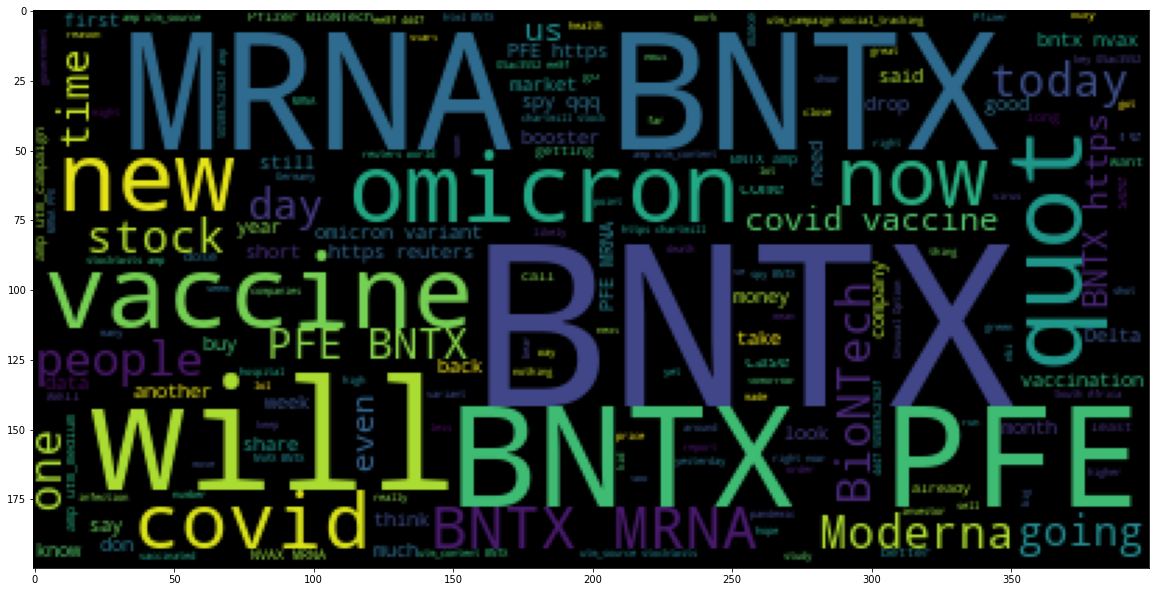

In [ ]:
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

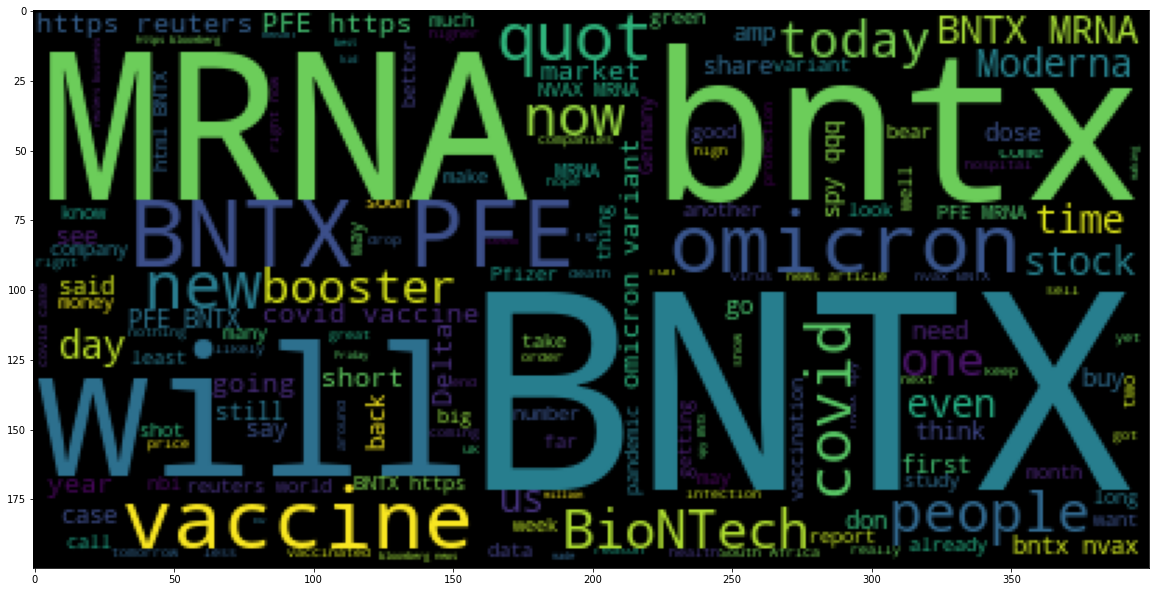

In [ ]:
#postive WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_positive))

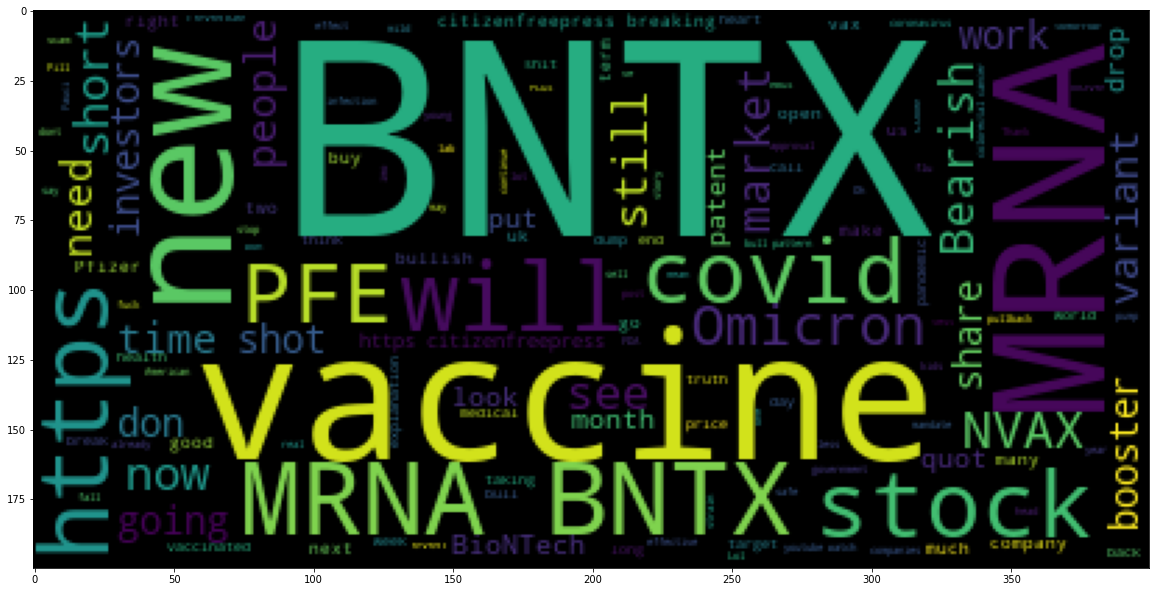

In [ ]:
#negative WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_negative))

## Data Preprocessing 
All unlabeled rows are dropped. 
I further delete all columns except for body (which contains the tweet) and basic sentiment which corresponds to the label.

In [31]:
dataset = dataset[['body','basic_sentiment']]
dataset = dataset.dropna()
dataset['basic_sentiment'] = dataset['basic_sentiment'].astype(int)
dataset.dtypes

body               object
basic_sentiment     int64
dtype: object

In [32]:
dataset

,body,basic_sentiment
0,$MRNA $bntx RIP Betty…$spy $qqq $pfe,0
1,$BNTX $PFE https://ig.ft.com/coronavirus-vacci...,0
3,$BNTX Happy new year longs!!,0
4,@Poundsand07 another ancient aliens quack you ...,0
5,@___dogd___ lol are you that dumb that you don...,0
...,...,...
6787,$BNTX $PFE White House considering stricter in...,0
6793,"$BNTX $PFE Nothing new, just for completeness ...",0
6794,$BNTX $PFE https://www.wsj.com/articles/omicro...,0
6796,$BNTX 400$,0


# Calculate the class weights 

In [33]:
pos, neg= np.bincount(dataset['basic_sentiment'])
total = pos+neg
print('positive sentiment (class 0):', pos,'\n negatives sentiment (class 1):',neg, '({:.2f}% of total)\n'.format(
     100 * neg / total))


positive sentiment (class 0): 3833 
 negatives sentiment (class 1): 147 (3.69% of total)



In [34]:
weight_for_0 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / neg) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (positives sentiment): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (negatives sentiment): {:.2f}'.format(weight_for_1))


Weight for class 0 (positives sentiment): 0.52
Weight for class 1 (negatives sentiment): 13.54


# Create a dataset.Dataset from pandas df

In [35]:
# create huggingface/ arrow dataset from pandas df
dataset = Dataset.from_pandas(dataset).remove_columns("__index_level_0__")


In [36]:
print("before: ",dataset.features)
# add labels to sentiment scores for better readability
feat_sentiment = ClassLabel(num_classes = 2,names=["negative", "positive"])
dataset = dataset.cast_column("basic_sentiment", feat_sentiment)
print("after: ", dataset.features)

before:  {'body': Value(dtype='string', id=None), 'basic_sentiment': Value(dtype='int64', id=None)}


Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

after:  {'body': Value(dtype='string', id=None), 'basic_sentiment': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}


In [37]:
#Split into training and test data
dataset_split = dataset.train_test_split(test_size=0.1) # to apply train_test_split I need to have a dataset not a datasetDict object 
train_data = dataset_split['train']
test_data = dataset_split['test']

#Split training data into training and validation data
train_data_split = train_data.train_test_split(test_size=1/9)
train_data = train_data_split['train']
validation_data = train_data_split['test']

dataset = DatasetDict({
    'train': train_data,
    'validation': validation_data,
    'test': test_data
})

print(dataset)
dataset['train'].features


DatasetDict({
    train: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 3184
    })
    validation: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 398
    })
    test: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 398
    })
})


{'basic_sentiment': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None),
 'body': Value(dtype='string', id=None)}

### Check distribution of labels wihtin the random subsamples and calculate the classweights





In [38]:
pos_train, neg_train = np.bincount(dataset['train']['basic_sentiment'])
print('positive sentiment (class 0):', pos_train,'\n negatives sentiment (class 1):',neg_train, '({:.2f}% of total)\n'.format(
     100 * neg / total))

positive sentiment (class 0): 3064 
 negatives sentiment (class 1): 120 (3.69% of total)



In [39]:
pos_valid, neg_valid = np.bincount(dataset['validation']['basic_sentiment'])
print('positive sentiment (class 0):', pos_valid,'\n negatives sentiment (class 1):',neg_valid, '({:.2f}% of total)\n'.format(
     100 * neg / total))


positive sentiment (class 0): 389 
 negatives sentiment (class 1): 9 (3.69% of total)



## Tokenization

In [40]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [41]:
# demonstrate tokenization
print('example:',dataset['train']['body'][0])
print('tokenization of the example:',tokenizer(dataset['train']['body'][0]))  #warum bekomme ich keine token_type_ids?
print('decode tokenization:',tokenizer.decode(tokenizer(dataset['train']['body'][0])['input_ids']))

example: $MRNA $BNTX 132m people unvaccinated in the U.S, good luck FJB you’ve got no chance forcing the rest… the market now is just for boosting the sheep concerning these two companies
tokenization of the example: {'input_ids': [101, 1002, 28848, 1002, 24869, 2102, 2595, 14078, 2213, 2111, 4895, 24887, 28748, 3064, 1999, 1996, 1057, 1012, 1055, 1010, 2204, 6735, 1042, 3501, 2497, 2017, 1521, 2310, 2288, 2053, 3382, 6932, 1996, 2717, 1529, 1996, 3006, 2085, 2003, 2074, 2005, 12992, 2075, 1996, 8351, 7175, 2122, 2048, 3316, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
decode tokenization: [CLS] $ mrna $ bntx 132m people unvaccinated in the u. s, good luck fjb you ’ ve got no chance forcing the rest … the market now is just for boosting the sheep concerning these two companies [SEP]


In [42]:
# apply a tokenizer function
def tokenize_function(dat):
   return tokenizer(dat["body"], truncation=True, padding = 'max_length')

tokenized_dataset = dataset.map(tokenize_function, batched = True)
print(tokenized_dataset)

print('example:',tokenized_dataset['train']['body'][0],'\ntokenized example:',tokenized_dataset['train']['input_ids'][0])
print('example:',tokenized_dataset['validation']['body'][0],'\ntokenized example:',tokenized_dataset['validation']['input_ids'][0])
# since padding is equal to max_length there are 0 added

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 3184
    })
    validation: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 398
    })
    test: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 398
    })
})
example: $MRNA $BNTX 132m people unvaccinated in the U.S, good luck FJB you’ve got no chance forcing the rest… the market now is just for boosting the sheep concerning these two companies 
tokenized example: [101, 1002, 28848, 1002, 24869, 2102, 2595, 14078, 2213, 2111, 4895, 24887, 28748, 3064, 1999, 1996, 1057, 1012, 1055, 1010, 2204, 6735, 1042, 3501, 2497, 2017, 1521, 2310, 2288, 2053, 3382, 6932, 1996, 2717, 1529, 1996, 3006, 2085, 2003, 2074, 2005, 12992, 2075, 1996, 8351, 7175, 2122, 2048, 3316, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

To train the model with the tokenized dataset it needs further modification.
* rename label column to labels which is expected by in BertForSequenceClassifiaction
* make dataset.Dataset to tensors
* filter the columns needed as model input [input_id, token_type_ids, attention_mask]

In [43]:
#rename the label column
#dataset = tokenized_dataset.map(lambda x: {'labels': x['basic_sentiment']}, batched=True)
tokenized_dataset = tokenized_dataset.map(lambda x: {'labels': x['basic_sentiment']}, batched= True)
dataset = tokenized_dataset.map(lambda x: {'labels': x['basic_sentiment']}, batched= True) # batched true make it faster 

print(dataset)
#print(tf_dataset['train']['basic_sentiment'][:10],tf_dataset['train']['labels'][:10])
print(dataset['train']['basic_sentiment'][:10],dataset['train']['labels'][:10])

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids', 'labels'],
        num_rows: 3184
    })
    validation: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids', 'labels'],
        num_rows: 398
    })
    test: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids', 'labels'],
        num_rows: 398
    })
})
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [44]:
dataset['train'].set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels']) #shuffle = True
features_train = {x: dataset['train'][x] for x in ['input_ids', 'attention_mask']}
tfdataset_train = tf.data.Dataset.from_tensor_slices((features_train, dataset['train']["labels"])).batch(16)
print(next(iter(tfdataset_train)))

dataset['validation'].set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels']) #shuffle = False
features_validation = {x: dataset['validation'][x] for x in ['input_ids', 'attention_mask']}
tfdataset_validation = tf.data.Dataset.from_tensor_slices((features_validation, dataset['validation']["labels"])).batch(16)
#next(iter(tfdataset_validation))

dataset['test'].set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels'])
features_test = {x: dataset['test'][x] for x in ['input_ids', 'attention_mask']}
tfdataset_test = tf.data.Dataset.from_tensor_slices((features_test, dataset['test']["labels"])).batch(16)
#next(iter(tfdataset_test))


({'input_ids': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
array([[  101,  1002, 28848, ...,     0,     0,     0],
       [  101,  1002, 28848, ...,     0,     0,     0],
       [  101,  1002, 28848, ...,     0,     0,     0],
       ...,
       [  101,  1002, 24869, ...,     0,     0,     0],
       [  101,  1002, 24869, ...,     0,     0,     0],
       [  101,  1002,  1050, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])>)


In [45]:
#alternative way to above not necessary to run
#in the following the column body is removed since it is a string and not needed anymore (information is in 'input ids')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=["input_ids", 'attention_mask'],
    label_cols= ["basic_sentiment"],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 16
)
tf_validation_dataset = tokenized_dataset['validation'].to_tf_dataset(
    columns=["input_ids",'attention_mask'],
    label_cols= ["basic_sentiment"],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 16
)

# Model Fine Tuning

## Setup TensorBoard

In [46]:
#create a tensorboard folder where all the files from training are saved
make_folder = '/tensorboard'

def create_and_set_working_directory(make_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + make_folder) == False:
    os.mkdir(root_dir + make_folder)
    print(root_dir + make_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + make_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + 
        # "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(make_folder)



Setup Tensorboard Callbacks

In [47]:
root_logdir = os.path.join(os.curdir, "logs")
def get_run_logdir(name: str = ""):
  import time
  run_id = time.strftime("%m_%d-%H_%M")
  run_name = run_id + name
  return os.path.join(root_logdir, run_name)

In [48]:
print(get_run_logdir('try'))

./logs/01_17-09_13try


Connect to HuggingFace

In [49]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Load the model

In [50]:
# create model - since this is a bert model, it will use
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [51]:
print(model.config.num_labels)
print(model.config.problem_type)

2
None


Introduce class weights to account for the imbalance of the dataset

In [52]:

# epoch, lr scheduler and optimizer
num_epochs = 3
num_train_steps = len(tf_train_dataset)*num_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)




In [53]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction='auto', from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Uncomment if you train on GPU that can train in mixed-precision
#tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [58]:
#Create Callbacks
#hub_cb = PushToHubCallback(
  #  output_dir = 'jule-finetuned-BERT', tokenizer=tokenizer, save_strategy='epoch'
#)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = get_run_logdir("tryout"), write_graph=True)
history = model.fit(tfdataset_train,validation_data= tfdataset_validation, epochs=3, class_weight = class_weight, callbacks=[tensorboard_cb])#callbacks=[hub_cb,tensorboard_cb])

TypeError: ignored

In [ ]:
#Inpsect model on tensorboard
%reload_ext tensorboard
%tensorboard --logdir=./logs

## Predictions

In [ ]:
pred = np.array(model.predict(tfdataset_test)['logits'])
probabilities = np.array(tf.nn.softmax(pred))
class_pred = np.array(np.argmax(probabilities, axis = 1))

In [ ]:
print(pred[:4])
print(probabilities[:4])
print(class_pred[:4])

In [ ]:
# correct test labels 
y_test = np.array(test_data['basic_sentiment'])
y_test[:5]


## Accuracy 

In [ ]:
#generate confusion matrix
cf_matrix = confusion_matrix(y_test,class_pred)
print(cf_matrix)


In [ ]:
#create a heatmap
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap = 'Blues')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['positive','negative'])
ax.yaxis.set_ticklabels(['postive','negative'])

In [ ]:
type(y_test)

In [ ]:
#metric = tfa.metrics.F1Score(num_classes=2, threshold=None)
metric.update_state(y_test, probabilities)
##result = metric.result()
#result.numpy()